In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import (cross_val_score, GridSearchCV, RandomizedSearchCV, learning_curve, validation_curve, train_test_split)
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
sns.set_style('darkgrid')

In [2]:
data =  pd.read_csv('finaldata.csv')
data.shape

(14999, 19)

In [4]:
x = data.loc[:, data.columns != "left"].values
y = data.loc[:, data.columns == "left"].values.flatten()
print(x)
print(y)

[[0.38 0.53 2.   ... 1.   0.   0.  ]
 [0.8  0.86 5.   ... 1.   0.   0.  ]
 [0.11 0.88 7.   ... 1.   0.   0.  ]
 ...
 [0.37 0.53 2.   ... 0.   1.   0.  ]
 [0.11 0.96 6.   ... 0.   1.   0.  ]
 [0.37 0.52 2.   ... 0.   1.   0.  ]]
[1 1 1 ... 1 1 1]


In [4]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify=y, random_state=1)

In [5]:
# Upsample minority class
from sklearn.utils import resample
x_train_u, y_train_u = resample(x_train[y_train == 1],
                                y_train[y_train == 1],
                                replace=True,
                                n_samples=x_train[y_train == 0].shape[0],
                                random_state=1)
x_train_u = np.concatenate((x_train[y_train == 0], x_train_u))
y_train_u = np.concatenate((y_train[y_train == 0], y_train_u))
print("Upsampled shape:", x_train_u.shape, y_train_u.shape)

Upsampled shape: (18284, 18) (18284,)


In [6]:
x_train_u
df = pd.DataFrame(y_train_u, columns=['target'])

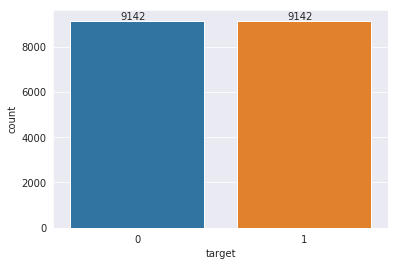

In [7]:
ax = sns.countplot('target', data = df)
for p in ax.patches:
        ax.annotate('{:}'.format(p.get_height()), (p.get_x()+0.3, p.get_height()+50))

In [8]:
# Downsample majority class
x_train_d, y_train_d = resample(x_train[y_train == 0],
                                y_train[y_train == 0],
                                replace=True,
                                n_samples=x_train[y_train == 1].shape[0],
                                random_state=1)
x_train_d = np.concatenate((x_train[y_train == 1], x_train_d))
y_train_d = np.concatenate((y_train[y_train == 1], y_train_d))


In [9]:
print("Downsampled shape:", x_train_d.shape, y_train_d.shape)

Downsampled shape: (5714, 18) (5714,)


In [10]:
x_train_d
df = pd.DataFrame(y_train_d, columns=['target'])

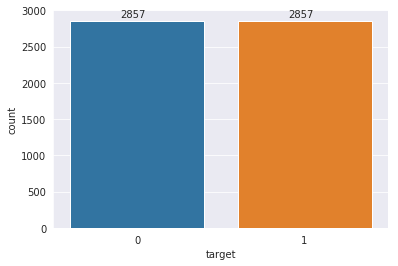

In [11]:
ax = sns.countplot('target', data = df)
for p in ax.patches:
        ax.annotate('{:}'.format(p.get_height()), (p.get_x()+0.3, p.get_height()+50))

In [12]:
print("Original shape:", x_train.shape, y_train.shape)

Original shape: (11999, 18) (11999,)


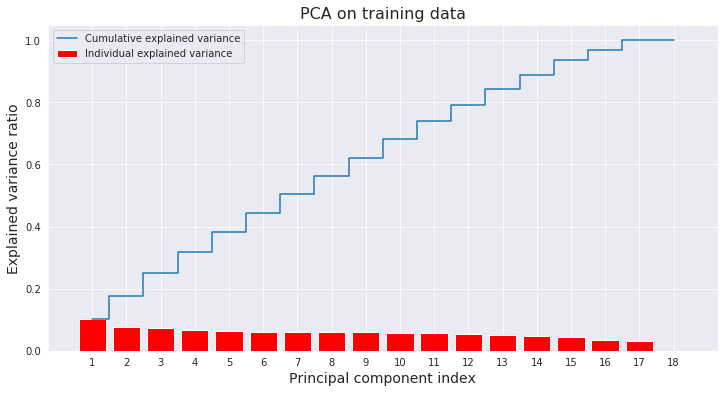

In [13]:
# Build PCA using standarized trained data
# %matplotlib notebook
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
pca = PCA(n_components=None, svd_solver="full")
pca.fit(StandardScaler().fit_transform(x_train))
cum_var_exp = np.cumsum(pca.explained_variance_ratio_)
plt.figure(figsize=(12, 6))
plt.bar(range(1, 19), pca.explained_variance_ratio_, align="center",
        color='red', label="Individual explained variance")
plt.step(range(1, 19), cum_var_exp, where="mid", label="Cumulative explained variance")
plt.xticks(range(1, 19))
plt.legend(loc="best")
plt.xlabel("Principal component index", {"fontsize": 14})
plt.ylabel("Explained variance ratio", {"fontsize": 14})
plt.title("PCA on training data", {"fontsize": 16});

In [14]:
cum_var_exp

array([0.10182713, 0.17736002, 0.2507649 , 0.31766474, 0.38183557,
       0.44360334, 0.50348558, 0.56283436, 0.62176125, 0.68030775,
       0.73844677, 0.79245839, 0.84181629, 0.88899063, 0.93472731,
       0.96966358, 1.        , 1.        ])

In [15]:
# Build random forest classifier
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
methods_data = {"Original": (x_train, y_train),
                "Upsampled": (x_train_u, y_train_u),
                "Downsampled": (x_train_d, y_train_d)}

for method in methods_data.keys():
    pip_rf = make_pipeline(StandardScaler(),
                           RandomForestClassifier(n_estimators=500,
                                                  class_weight="balanced",
                                                  random_state=123))
    
    hyperparam_grid = {
        "randomforestclassifier__n_estimators": [10, 50, 100, 500],
        "randomforestclassifier__max_features": ["sqrt", "log2", 0.4, 0.5],
        "randomforestclassifier__min_samples_leaf": [1, 3, 5],
        "randomforestclassifier__criterion": ["gini", "entropy"]}
    
    gs_rf = GridSearchCV(pip_rf,
                         hyperparam_grid,
                         scoring="f1",
                         cv=10,
                         n_jobs=-1)
    
    gs_rf.fit(methods_data[method][0], methods_data[method][1])
    
    print("\033[1m" + "\033[0m" + "The best hyperparameters for {} data:".format(method))
    for hyperparam in gs_rf.best_params_.keys():
        print(hyperparam[hyperparam.find("__") + 2:], ": ", gs_rf.best_params_[hyperparam])
        
    print("\033[1m" + "\033[94m" + "Best 10-folds CV f1-score: {:.2f}%.".format((gs_rf.best_score_) * 100))

The best hyperparameters for Original data:
criterion :  gini
max_features :  0.5
min_samples_leaf :  1
n_estimators :  500
Best 10-folds CV f1-score: 98.21%.
The best hyperparameters for Upsampled data:
criterion :  gini
max_features :  0.4
min_samples_leaf :  1
n_estimators :  100
Best 10-folds CV f1-score: 99.80%.
The best hyperparameters for Downsampled data:
criterion :  gini
max_features :  0.5
min_samples_leaf :  1
n_estimators :  500
Best 10-folds CV f1-score: 98.41%.


In [16]:
# Reassign original training data to upsampled data
from sklearn.metrics import (accuracy_score, f1_score, precision_score, recall_score, roc_auc_score,
                             roc_curve, confusion_matrix)
x_train, y_train = np.copy(x_train_u), np.copy(y_train_u)

# Delete original and downsampled data
del x_train_u, y_train_u, x_train_d, y_train_d

# Refit RF classifier using best params
clf_rf = make_pipeline(StandardScaler(),
                       RandomForestClassifier(n_estimators=50,
                                              criterion="gini",
                                              max_features=0.5,
                                              min_samples_leaf=1,
                                              class_weight="balanced",
                                              n_jobs=-1,
                                              random_state=123))


clf_rf.fit(x_train, y_train)

# Plot confusion matrix and ROC curve

Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('randomforestclassifier', RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features=0.5,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
...imators=50, n_jobs=-1, oob_score=False, random_state=123,
            verbose=0, warm_start=False))])

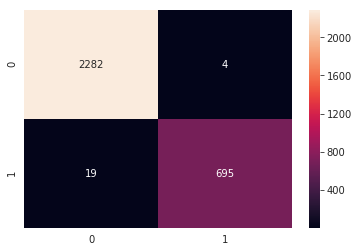

In [17]:
prediction = clf_rf.predict(x_test)
cm = confusion_matrix(y_test, prediction)
sns.heatmap(cm, annot=True,fmt='g')

In [18]:
print('Accuracy_Socre: ',accuracy_score(y_test, prediction))
print('F1 Score: ',f1_score(y_test, prediction))
print('Precision_Socre',precision_score(y_test, prediction))
print('Recall_Score',recall_score(y_test, prediction))

Accuracy_Socre:  0.9923333333333333
F1 Score:  0.983722576079264
Precision_Socre 0.994277539341917
Recall_Score 0.9733893557422969


0.9858197872324782


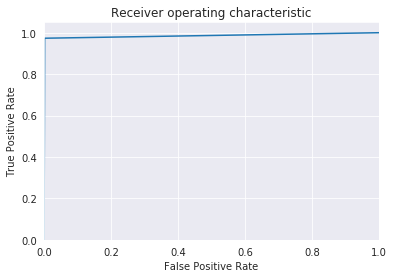

In [19]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(y_test, prediction)
    roc_auc[i] = auc(fpr[i], tpr[i])

print (roc_auc_score(y_test, prediction))
plt.figure()
plt.plot(fpr[1], tpr[1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.show()

In [20]:
# Build Gradient Boosting classifier
pip_gb = make_pipeline(StandardScaler(),
                       GradientBoostingClassifier(loss="deviance",
                                                  random_state=123))

hyperparam_grid = {"gradientboostingclassifier__max_features": ["log2", 0.5],
                   "gradientboostingclassifier__n_estimators": [100, 300, 500],
                   "gradientboostingclassifier__learning_rate": [0.001, 0.01, 0.1],
                   "gradientboostingclassifier__max_depth": [1, 2, 3]}

clf = GridSearchCV(pip_gb,
                      param_grid=hyperparam_grid,
                      scoring="f1",
                      cv=10,
                      n_jobs=-1)

clf.fit(x_train, y_train)

print("\033[1m" + "\033[0m" + "The best hyperparameters:")
print("-" * 25)
for hyperparam in clf.best_params_.keys():
    print(hyperparam[hyperparam.find("__") + 2:], ": ", clf.best_params_[hyperparam])

print("\033[1m" + "\033[94m" + "Best 10-folds CV f1-score: {:.2f}%.".format((clf.best_score_) * 100))



The best hyperparameters:
-------------------------
learning_rate :  0.1
max_depth :  3
max_features :  0.5
n_estimators :  500
Best 10-folds CV f1-score: 97.94%.


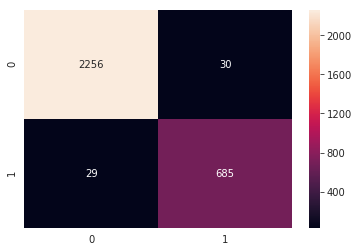

In [21]:
prediction = clf.predict(x_test)
cm = confusion_matrix(y_test, prediction)
sns.heatmap(cm, annot=True,fmt='g')

In [22]:
print('Accuracy_Socre: ',accuracy_score(y_test, prediction))
print('F1 Score: ',f1_score(y_test, prediction))
print('Precision_Socre',precision_score(y_test, prediction))
print('Recall_Score',recall_score(y_test, prediction))

Accuracy_Socre:  0.9803333333333333
F1 Score:  0.9587123862841148
Precision_Socre 0.958041958041958
Recall_Score 0.9593837535014006


0.973130196960674


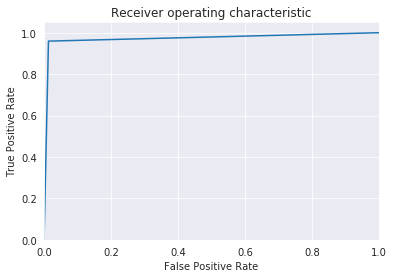

In [23]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(y_test, prediction)
    roc_auc[i] = auc(fpr[i], tpr[i])

print (roc_auc_score(y_test, prediction))
plt.figure()
plt.plot(fpr[1], tpr[1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.show()

In [26]:
# Build KNN classifier
pip_knn = make_pipeline(StandardScaler(), KNeighborsClassifier())
hyperparam_range = range(1, 20)

clf = GridSearchCV(pip_knn,
                      param_grid={"kneighborsclassifier__n_neighbors": hyperparam_range,
                                  "kneighborsclassifier__weights": ["uniform", "distance"]},
                      scoring="f1",
                      cv=10,
                      n_jobs=-1)

clf.fit(x_train, y_train)


print("\033[1m" + "\033[0m" + "The best hyperparameters:")
print("-" * 25)
for hyperparam in clf.best_params_.keys():
    print(hyperparam[hyperparam.find("__") + 2:], ": ", clf.best_params_[hyperparam])

print("\033[1m" + "\033[94m" + "Best 10-folds CV f1-score: {:.2f}%.".format((clf.best_score_) * 100))

The best hyperparameters:
-------------------------
n_neighbors :  1
weights :  uniform
Best 10-folds CV f1-score: 98.24%.


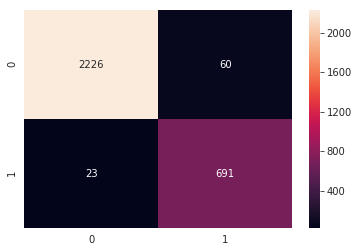

In [27]:
prediction = clf.predict(x_test)
cm = confusion_matrix(y_test, prediction)
sns.heatmap(cm, annot=True,fmt='g')

In [28]:
print('Accuracy_Socre: ',accuracy_score(y_test, prediction))
print('F1 Score: ',f1_score(y_test, prediction))
print('Precision_Socre',precision_score(y_test, prediction))
print('Recall_Score',recall_score(y_test, prediction))

Accuracy_Socre:  0.9723333333333334
F1 Score:  0.943344709897611
Precision_Socre 0.9201065246338216
Recall_Score 0.9677871148459384


0.9707701978429167


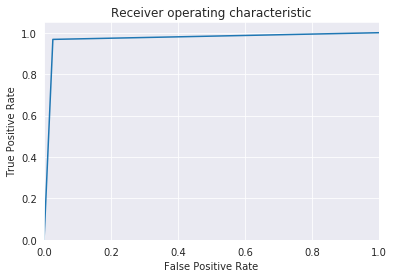

In [29]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(y_test, prediction)
    roc_auc[i] = auc(fpr[i], tpr[i])

print (roc_auc_score(y_test, prediction))
plt.figure()
plt.plot(fpr[1], tpr[1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.show()

In [31]:
# Build logistic model classifier
pip_logmod = make_pipeline(StandardScaler(),
                           LogisticRegression(class_weight="balanced"))

hyperparam_range = np.arange(0.5, 20.1, 0.5)

hyperparam_grid = {"logisticregression__penalty": ["l1", "l2"],
                   "logisticregression__C":  hyperparam_range,
                   "logisticregression__fit_intercept": [True, False]
                  }

clf = GridSearchCV(pip_logmod,
                           hyperparam_grid,
                           scoring="accuracy",
                           cv=2,
                           n_jobs=-1)

clf.fit(x_train, y_train)

print("\033[1m" + "\033[0m" + "The best hyperparameters:")
print("-" * 25)
for hyperparam in clf.best_params_.keys():
    print(hyperparam[hyperparam.find("__") + 2:], ": ", clf.best_params_[hyperparam])

print("\033[1m" + "\033[94m" + "Best 10-folds CV f1-score: {:.2f}%.".format((clf.best_score_) * 100))

/home/kuldeep/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


The best hyperparameters:
-------------------------
C :  1.5
fit_intercept :  True
penalty :  l1
Best 10-folds CV f1-score: 77.20%.


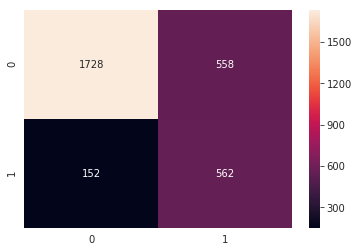

In [32]:
prediction = clf.predict(x_test)
cm = confusion_matrix(y_test, prediction)
sns.heatmap(cm, annot=True,fmt='g')

In [33]:
print('Accuracy_Socre: ',accuracy_score(y_test, prediction))
print('F1 Score: ',f1_score(y_test, prediction))
print('Precision_Socre',precision_score(y_test, prediction))
print('Recall_Score',recall_score(y_test, prediction))

Accuracy_Socre:  0.7633333333333333
F1 Score:  0.6128680479825518
Precision_Socre 0.5017857142857143
Recall_Score 0.7871148459383753


0.7715101788746994


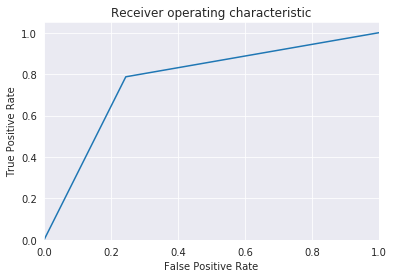

In [34]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(y_test, prediction)
    roc_auc[i] = auc(fpr[i], tpr[i])

print (roc_auc_score(y_test, prediction))
plt.figure()
plt.plot(fpr[1], tpr[1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.show()

In [37]:
# Build SVM classifier
clf = make_pipeline(StandardScaler(),
                        SVC(C=0.01,
                            gamma=0.1,
                            kernel="poly",
                            degree=5,
                            coef0=10,
                            probability=True))

clf.fit(x_train, y_train)

svc_cv_scores = cross_val_score(clf, X=x_train, y=y_train, scoring="f1", cv=10, n_jobs=-1)

# Print CV
print("\033[1m" + "\033[94m" + "The 10-folds CV f1-score is: {:.2f}%".format(
       np.mean(svc_cv_scores) * 100))

The 10-folds CV f1-score is: 96.46%


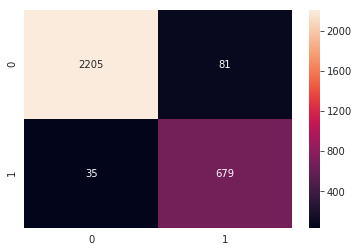

In [38]:
prediction = clf.predict(x_test)
cm = confusion_matrix(y_test, prediction)
sns.heatmap(cm, annot=True,fmt='g')

In [39]:
print('Accuracy_Socre: ',accuracy_score(y_test, prediction))
print('F1 Score: ',f1_score(y_test, prediction))
print('Precision_Socre',precision_score(y_test, prediction))
print('Recall_Score',recall_score(y_test, prediction))

Accuracy_Socre:  0.9613333333333334
F1 Score:  0.9213025780189958
Precision_Socre 0.8934210526315789
Recall_Score 0.9509803921568627


0.9577736606453605


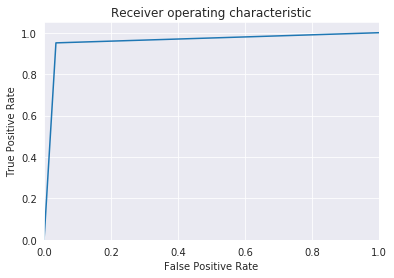

In [40]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(y_test, prediction)
    roc_auc[i] = auc(fpr[i], tpr[i])

print (roc_auc_score(y_test, prediction))
plt.figure()
plt.plot(fpr[1], tpr[1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.show()